## 数据

In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
prostate = pd.read_csv("../../../datasets/prostate/prostate.data", 
                       sep="\t", index_col=0)
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
train_data = prostate.drop("train", axis=1)[prostate["train"] == "T"]
test_data = prostate.drop("train", axis=1)[prostate["train"] == "F"]

scaler = StandardScaler().fit(train_data)
train_data_std = scaler.fit_transform(train_data)
test_data_std = scaler.transform(test_data)
X_train = train_data_std[:, :-1]
y_train = train_data_std[:, -1]
X_test = test_data_std[:, :-1]
y_test = test_data_std[:, -1]

## 向前逐阶段回归

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [63]:
class FrowardStageRegression(BaseEstimator, RegressorMixin):
    """向前逐段回归
    
    参数：
    -----
    n_stages: 阶段的数量，默认是500
    alpha：正则化参数，控制每前进一步的步长，相当于学习率
    
    属性：
    -----
    Beta：系数
    feature_order: 记录特征依次添加的顺序
    loss_history: 记录添加每个特征后的均方根误差
    """
    def __init__(self, n_stages=200, alpha=0.1, normalized=False):
        self.n_stages = n_stages
        self.alpha = alpha
        self.normalized = normalized
        
    def fit(self, X, y):
        if self.normalized:
            X = (X - X.mean(axis=0)) / np.std(X)
        n, p = X.shape
        self.beta_path = np.zeros([self.n_stages, p])
        corrs = np.zeros(p)
        r = y.copy()
        max_idx_set = []
        self.loss_history = []  # 记录历史的残差
        for i in range(self.n_stages):
            # 遍历各个变量并选出与当前残差相关性最大的变量
            for j in range(p):
                corrs[j] = np.corrcoef(X[:,j], r)[0][1]
            max_idx = np.argmax(corrs)
            max_idx_set.append(max_idx)
            delta = self.alpha * np.sign(corrs[max_idx])
            if delta < 0:  # 如果出现负相关就停止
                break
            self.beta_path[i, :] = self.beta_path[i - 1, :].copy()
            self.beta_path[i, max_idx] += delta  # 更新系数
            r = r - delta * X[:, max_idx] # 更新残差
            loss = np.sqrt(np.sum(r**2))
            self.loss_history.append(loss)
            
        beta_idx = np.array([np.argmax(self.beta_path[:, i]) for i in range(p)])
        stage_best = beta_idx[np.argmin(beta_idx[beta_idx != 0])]
        beta_best = self.beta_path[int(stage_best)]
        intercept_corr = np.ones(n).T @ (y - y.mean()) # 加入截距的相关性
        self.Beta = np.r_[intercept_corr, beta_best]
        self.feature_order = np.unique(max_idx_set)
        
        return self
    
    def predict(self, X):
        if self.normalized:
            X = (X - X.mean(axis=0)) / np.std(X)
        X = np.c_[np.ones(len(X)), X]
        y_pred = X @ self.Beta
        
        return y_pred

In [64]:
fsr = FrowardStageRegression()
fsr.fit(X_train, y_train)

FrowardStageRegression()

In [65]:
y_train_preds = fsr.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.460


In [66]:
y_test_preds = fsr.predict(X_test)
test_err = mean_squared_error(y_test, y_test_preds)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.370


In [67]:
fsr.Beta

array([0. , 0.5, 0.1, 0. , 0. , 0. , 0. , 0. , 0. ])

In [68]:
print("特征依次添加的顺序:{}".format(fsr.feature_order))

特征依次添加的顺序:[0 1 3 4 7]


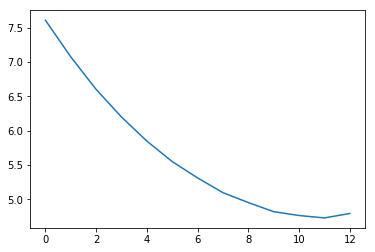

In [82]:
loss_history = fsr.loss_history
plt.plot(range(len(loss_history)), loss_history)
plt.show()

### 寻找最优参数

In [70]:
from sklearn.model_selection import GridSearchCV
import humanfriendly as hf
import time

In [71]:
start = time.perf_counter()
n_stages_lst = np.arange(100, 2000, 100)
alpha_lst = [0.001, 0.01, 0.1, 0.3, 0.5]
param_grid = {'n_stages': n_stages_lst,
              'alpha': alpha_lst}
fsr_cv = GridSearchCV(FrowardStageRegression(), 
                      param_grid=param_grid, 
                      cv=10, 
                      scoring='neg_mean_squared_error', 
                      n_jobs=-1,
                      return_train_score=True)
fsr_cv.fit(X_train, y_train)
end = time.perf_counter()
elapsed_ls = end - start
time_cost = hf.format_timespan(elapsed_ls)
print("所用时间：{}".format(time_cost))

所用时间：3 minutes and 8.51 seconds


In [73]:
best_param = fsr_cv.best_params_
best_param

{'alpha': 0.001, 'n_stages': 900}

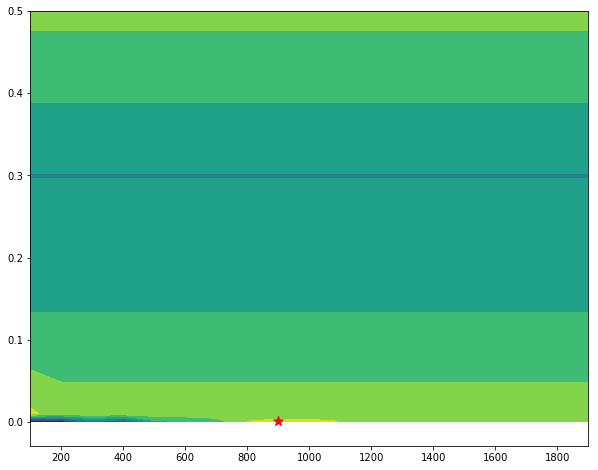

In [74]:
cv_scores = fsr_cv.cv_results_["mean_test_score"]
xx1, xx2 = np.meshgrid(n_stages_lst, alpha_lst)
cv_scores = cv_scores.reshape(xx1.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx1, xx2, cv_scores)
plt.scatter(best_param["n_stages"], best_param["alpha"],
            marker="*", color="red", s=100)
plt.plot()
plt.show()

### 使用最优模型

In [76]:
fsr_best = fsr_cv.best_estimator_

In [77]:
y_train_preds = fsr_best.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.364


In [78]:
y_test_preds = fsr_best.predict(X_test)
test_err = mean_squared_error(y_test, y_test_preds)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.315


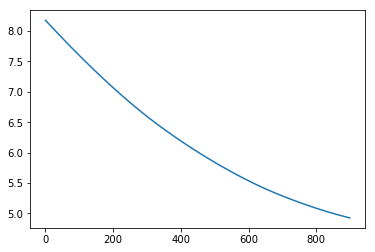

In [79]:
loss_history = fsr_best.loss_history
plt.plot(range(len(loss_history)), loss_history)
plt.show()

### 系数路径

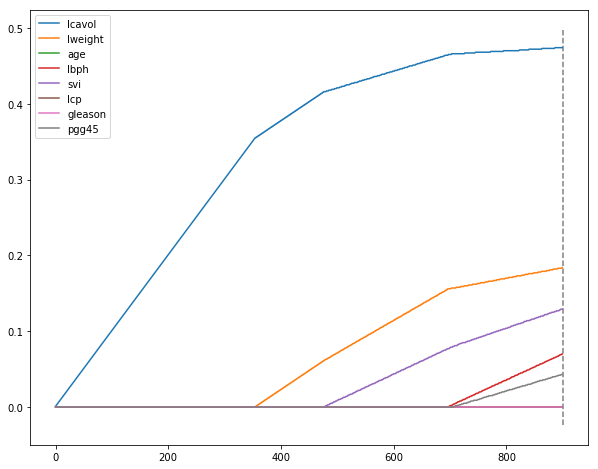

In [85]:
p = X_train.shape[1]
best_n_stages = best_param["n_stages"]
plt.figure(figsize=(10, 8))
for i in range(p):
    plt.plot(range(best_n_stages), fsr_best.beta_path[:, i], 
             label=list(train_data.columns)[i])
plt.vlines(best_n_stages, plt.ylim()[0], plt.ylim()[1], color='gray', linestyles='--')
plt.legend()
plt.show()

In [76]:
pd.options.display.float_format = '{:.3f}'.format
intercept = train_data['lpsa'].values.mean()
variables = ["Intercept"] + list(train_data.iloc[:, :-1].columns)
pd.DataFrame({"Term": variables, 
              "Coefficient": fsr_best.Beta})

,Term,Coefficient
0,Intercept,0.000
1,lcavol,0.474
2,lweight,0.182
3,age,0.000
4,lbph,0.065
5,svi,0.126
6,lcp,0.000
7,gleason,0.000
8,pgg45,0.040
